## 2: Scalecast LSTM Model

Lucy Herr
<br>  3/1/24
<br>  UCB MIDS Capstone Spring 2024

scalecast lstm sources: 
- https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#lstm
- https://scalecast-examples.readthedocs.io/en/latest/lstm/lstm_latest.html
- https://towardsdatascience.com/five-practical-applications-of-the-lstm-model-for-time-series-with-code-a7aac0aa85c0
- https://mikekeith52.medium.com/stacking-time-series-models-to-improve-accuracy-7977c6667d29
- https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

Tensorflow LSTM sources:
- best/most comprehensive documentation: https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://medium.com/@vineet.pandya/use-tensorflow-lstm-for-time-series-forecasting-770ec789d2ce
- https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

general lstm:
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ 

In [170]:
import pandas as pd
import numpy as np 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM forecasting
from scalecast.Forecaster import Forecaster
# grid search
from scalecast import GridGenerator

# pipeline
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation,
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from tensorflow.keras.callbacks import EarlyStopping
from scalecast.MVForecaster import MVForecaster
from scalecast.Pipeline import MVPipeline
from scalecast.util import find_optimal_transformation, backtest_metrics

In [174]:
# %cd '/Users/lucymherr/capstone/lucy'
# %pwd

/Users/lucymherr/capstone/lucy


'/Users/lucymherr/capstone/lucy'

In [208]:
# lstm_train = pd.read_csv("split_data/lstm_train.csv")
# lstm_val = pd.read_csv("split_data/lstm_val.csv")
lstm_trainval = pd.read_csv("split_data/lstm_trainval.csv")

In [209]:
lstm_trainval.shape

(4408, 100)

In [197]:
4408-4397

11

### Initialize Forecaster object for modeling

In [27]:
# initialize forecaster object
f0 = Forecaster(
    y=y_train.county_all_drugs_monthly_rate, # array of all observed y-vals
    current_dates=lstm_train.period, # array of all observed dates
    require_future_dates=True, # default
    future_dates=6, # default
    test_length=0, # validation set to consist of 20% of train observations
    cis=False, # evaluate naive conformal CIs for each model, default=False
    metrics = ['rmse'] # default metrics for validation
)
# display object attributes
f0

Forecaster(
    DateStartActuals=2016-02-01T00:00:00.000000000
    DateEndActuals=2021-08-01T00:00:00.000000000
    Freq=None
    N_actuals=3856
    ForecastLength=6
    Xvars=[]
    TestLength=771
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Test series' stationarity 

In [62]:
# Test for stationarity in series: Augmented Dickey-Fuller test
stat, pval, used_lag_int, n_obs, crit_vals_dict, res_class = f0.adf_test(critical_pval=0.05, full_res=True, train_only=True, diffy=False)
print(f"The ADF test of the training data's stationarity was significant (p={pval}).")

The ADF test of the training data's stationarity was significant (p=1.8921549612503203e-07).


In [43]:
# descriptive plot of observed values --> refine this with finalized data
# f.plot()
# plt.show()

### Inspect Autocorrelation: ACF Plot
- caveat: not suitable for non-stationary time series

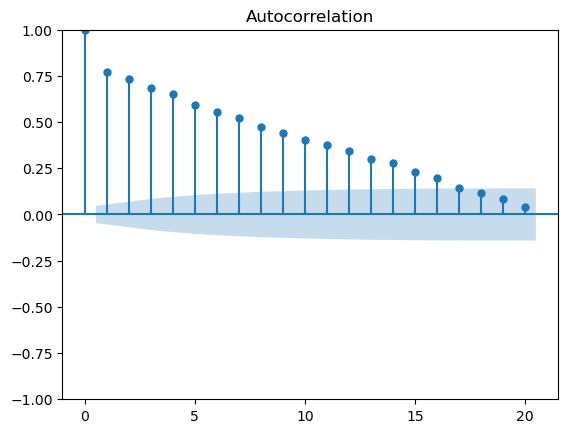

In [51]:
f0.plot_acf(lags=20)
plt.show()

Observations based on ACF plot: 
- Only sharp cutoff occurs between lag 0 and lag 1.
- Statistically non-0 ACF values through lag1-16 
- Gradual, visually linear decay from lag 1 onwards 

### Inspect Partial Autocorrelation: PACF Plot
- caveat: not suitable for non-stationary time series

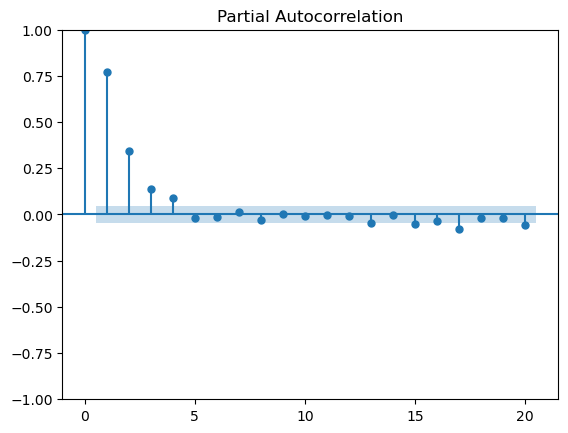

In [52]:
# # partial correlation of stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. 
f0.plot_pacf(lags=20)
plt.show()

Observations based on PACF plot: 
- Sharp decreases in PACF values following lag=1 and lag=2 (and, to a lesser extent, lag=3) may suggest seasonal patterns relevant for modeling. 
- This plot does not show gradual decay indicative of seasonality.
- Most values from lag 5 upwards fall within 95% CI (not statistically non-zero), with the exception of 13,15,17,20 (all slightly negative)

In [67]:
# decompose series into trend, seasonal, and residual components
# #ERROR: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

# f0.seasonal_decompose().plot()
# plt.show()

### Build and Train Initial LSTM Model

Epoch 1/5
147/147 [==============================] - 4s 8ms/step - loss: 8.2774e-04 - val_loss: 3.2033e-04
Epoch 2/5
147/147 [==============================] - 0s 2ms/step - loss: 8.2932e-04 - val_loss: 3.1909e-04
Epoch 3/5
147/147 [==============================] - 0s 2ms/step - loss: 8.3380e-04 - val_loss: 3.0345e-04
Epoch 4/5
147/147 [==============================] - 0s 2ms/step - loss: 8.3112e-04 - val_loss: 3.1792e-04
Epoch 5/5
1/1 [==============================] - 1s 533ms/step


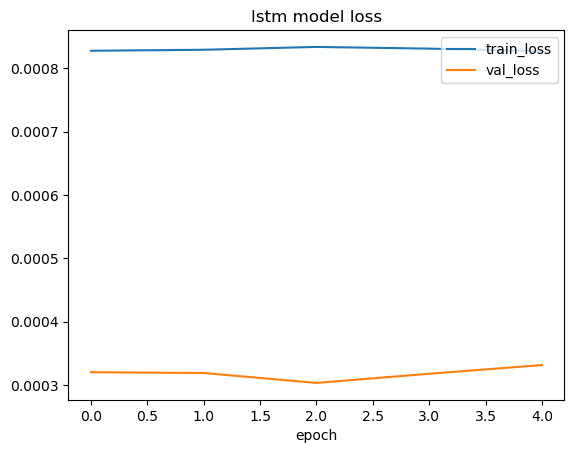

Epoch 1/5
147/147 [==============================] - 3s 7ms/step - loss: 8.3015e-04 - val_loss: 3.1899e-04
Epoch 2/5
147/147 [==============================] - 0s 2ms/step - loss: 8.2522e-04 - val_loss: 3.2035e-04
Epoch 3/5
147/147 [==============================] - 0s 2ms/step - loss: 8.2711e-04 - val_loss: 3.0920e-04
Epoch 4/5
147/147 [==============================] - 0s 2ms/step - loss: 8.2733e-04 - val_loss: 3.3657e-04
Epoch 5/5
138/138 [==============================] - 0s 760us/step


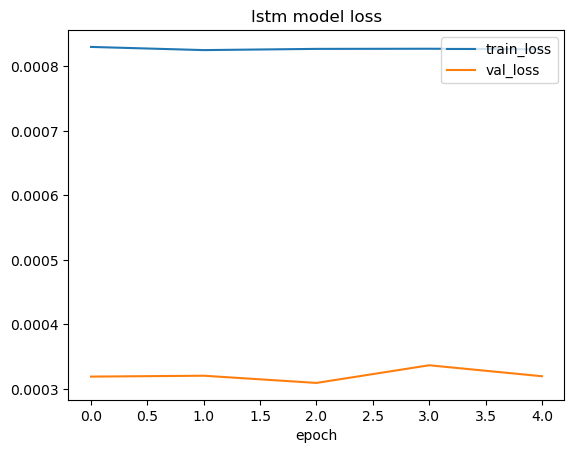

<Axes: xlabel='Date', ylabel='Values'>

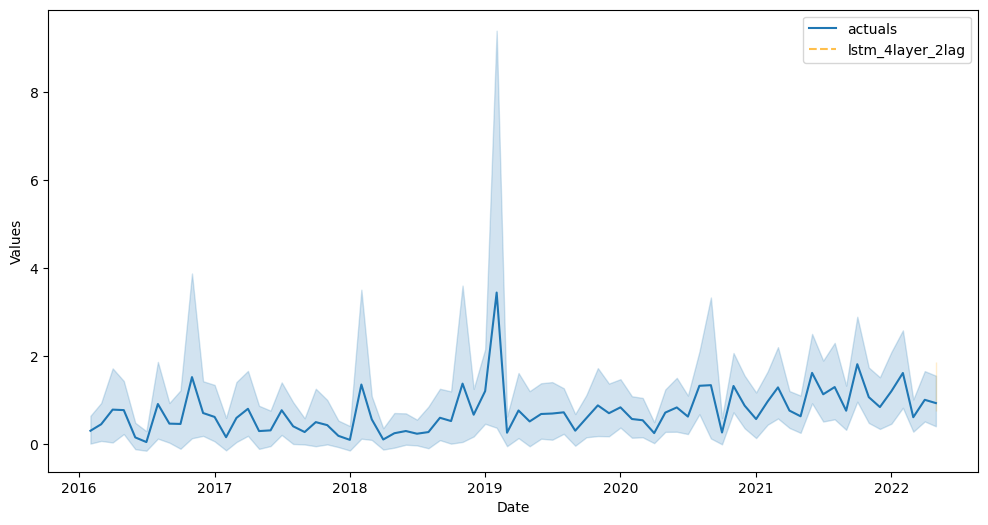

In [211]:
f3 = Forecaster(
    y=lstm_trainval.county_all_drugs_monthly_rate, # array of all observed y-vals
    current_dates=lstm_trainval.period, # array of all observed dates
    require_future_dates=True, # default
    future_dates=12, # default
    test_length=12, # validation set to consist of 20% of train observations
    cis=False, # evaluate naive conformal CIs for each model, default=False
    metrics = ['rmse'] # default metrics for validation
)

#f3.set_test_length(20)       # 1. 12 observations to test the results

f3.set_estimator('lstm') # LSTM neural network
f3.manual_forecast(
    lags=2, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_4layer_2lag',
    validation_split=.5,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    plot_loss=True,
    learning_rate=0.01, # ""
    lstm_layer_sizes=(4,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_4layer_2lag'])

In [30]:
# calc rmse from val loss? 
np.sqrt(3.7697e-04)

0.019415715284274233

## TO DO: Grid search 

In [ ]:
# rnn_grid = gen_rnn_grid(
#     layer_tries = 10,
#     min_layer_size = 3,
#     max_layer_size = 5,
#     units_pool = [100],
#     epochs = [100],
#     dropout_pool = [0,0.05],
#     validation_split=.2,
#     callbacks=EarlyStopping(
#       monitor='val_loss',
#       patience=3,
#     ),
#     random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [159]:
# alternative manual_forecast syntax to build function? 

# def forecaster(f):
#     f.set_estimator('rnn')
#     f.manual_forecast(
#         lags = 2,
#         layers_struct = [
#             ('LSTM',{'units':36,'activation':'tanh'}),
#         ],
#         epochs=5,
#         call_me = 'lstm',
#     )

121/121 [==============================] - 0s 555us/step


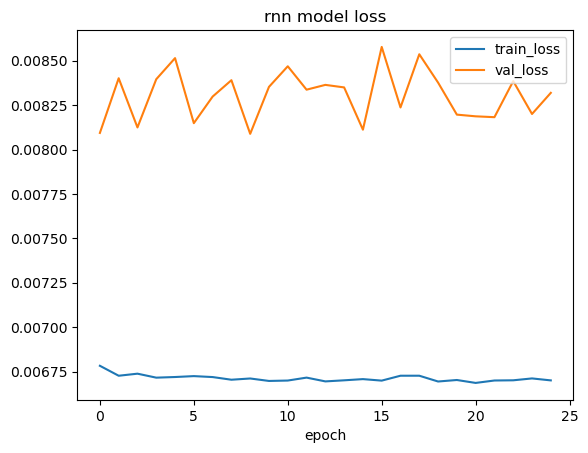

In [59]:
# f0.manual_forecast(
#     layers_struct=[('LSTM',{'units':36,'activation':'tanh'}))],
#     epochs=25,
#     validation_split=0.2,
#     plot_loss=True, # working 
#     call_me="lstm2",
#     verbose=0, # so it doesn't print each epoch and saves space in the notebook
# )

### 'lstm_simple' (default LSTM settings)

#### scalecast LSTM defaults (from documentation): 
- single input layer of size 8, Adam optimizer, tanh activation, a single lagged dependent-variable value to train with, 
- a learning rate of 0.001, and no dropout.
- All data is scaled going into the model with a min-max scaler and un-scaled coming out.
- Anything you can pass to the fit() method in TensorFlow, you can also pass to the scalecast manual_forecast() method.
- f.manual_forecast(call_me='lstm_default')
- f.plot_test_set(ci=True)

1/1 [==============================] - 0s 190ms/step


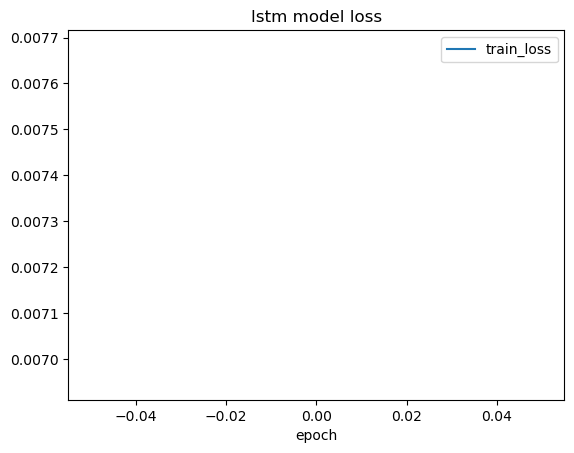

138/138 [==============================] - 0s 495us/step


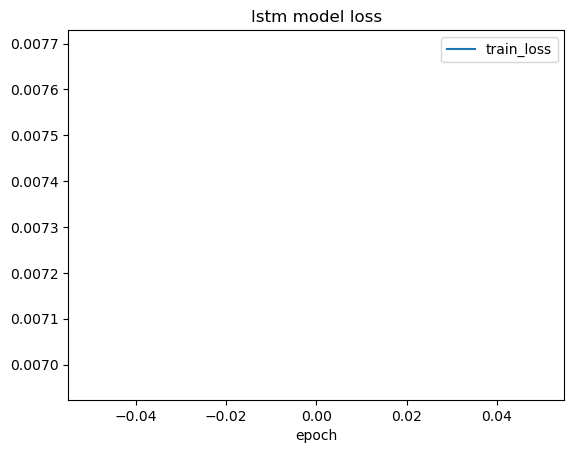

<Axes: xlabel='Date', ylabel='Values'>

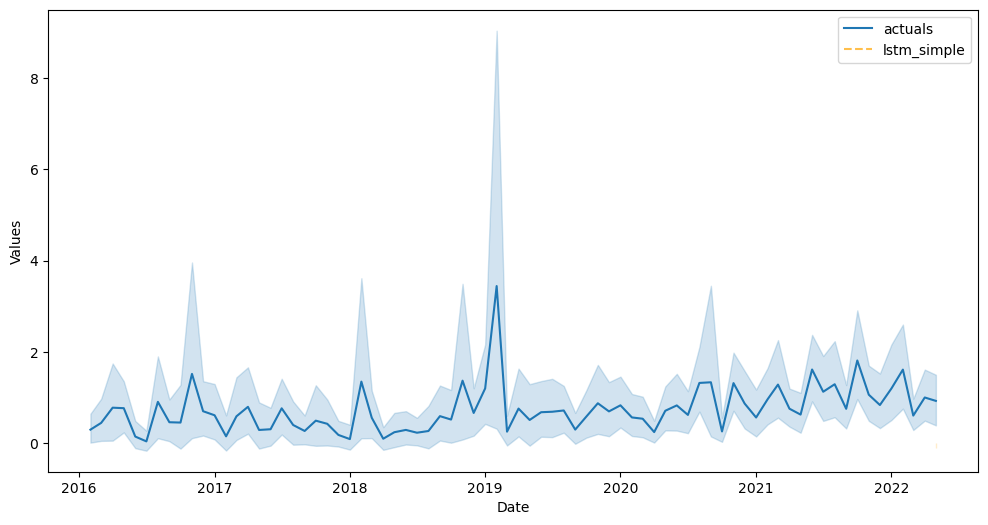

In [191]:
f3.set_estimator('lstm')
f3.manual_forecast(call_me='lstm_simple',lags=1,plot_loss=True)
f3.plot_test_set(ci=False,models=['lstm_simple'],order_by='TestSetRMSE')

### 'lstm_4layer'

Epoch 1/5
205/205 [==============================] - 4s 5ms/step - loss: 6.4312e-04 - val_loss: 3.9587e-04
Epoch 2/5
205/205 [==============================] - 0s 2ms/step - loss: 6.3937e-04 - val_loss: 3.7973e-04
Epoch 3/5
205/205 [==============================] - 0s 2ms/step - loss: 6.3634e-04 - val_loss: 3.6250e-04
Epoch 4/5
205/205 [==============================] - 0s 2ms/step - loss: 6.3787e-04 - val_loss: 3.8651e-04
Epoch 5/5
1/1 [==============================] - 1s 509ms/step


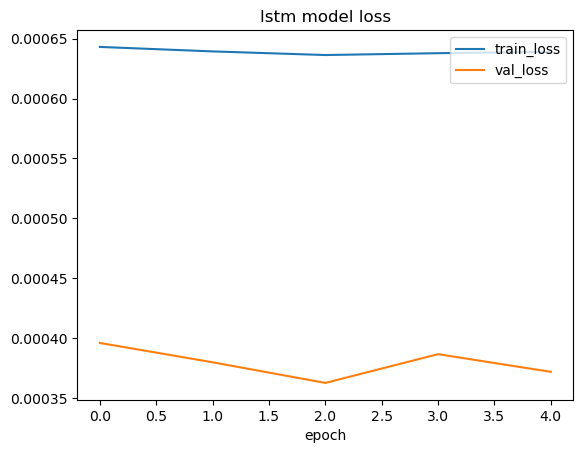

Epoch 1/5
206/206 [==============================] - 4s 5ms/step - loss: 6.4411e-04 - val_loss: 3.7709e-04
Epoch 2/5
206/206 [==============================] - 0s 2ms/step - loss: 6.3957e-04 - val_loss: 3.7347e-04
Epoch 3/5
206/206 [==============================] - 0s 2ms/step - loss: 6.4063e-04 - val_loss: 3.6356e-04
Epoch 4/5
206/206 [==============================] - 0s 2ms/step - loss: 6.3818e-04 - val_loss: 3.6890e-04
Epoch 5/5
138/138 [==============================] - 0s 778us/step


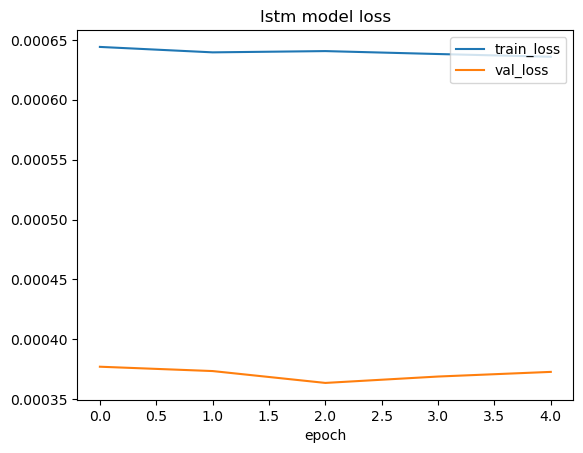

<Axes: xlabel='Date', ylabel='Values'>

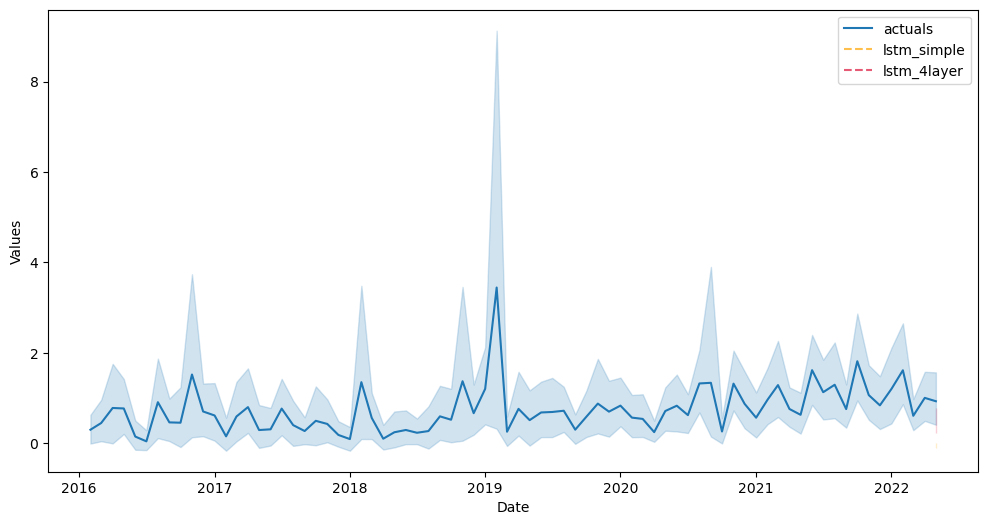

In [192]:
f3.manual_forecast(
    #lags=1, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_4layer',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    plot_loss=True,
    learning_rate=0.005, # ""
    lstm_layer_sizes=(16,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer'],order_by='TestSetRMSE')

### 'lstm_4layer_1lag'

In [200]:
#f3.set_test_length(20)       # 1. 12 observations to test the results
f3.manual_forecast(
    lags=1, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_4layer_1lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    plot_loss=True,
    learning_rate=0.001, # ""
    lstm_layer_sizes=(4,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer','lstm_4layer_1lag'],order_by='TestSetRMSE')

ForecastError: Need at least 1 Xvar to forecast with the mlr model.

### 'lstm_8layer_2lag'

Epoch 1/5
124/124 [==============================] - 4s 9ms/step - loss: 7.4238e-04 - val_loss: 6.6611e-04
Epoch 2/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4222e-04 - val_loss: 6.6527e-04
Epoch 3/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4296e-04 - val_loss: 6.6326e-04
Epoch 4/5
124/124 [==============================] - 0s 2ms/step - loss: 7.4229e-04 - val_loss: 6.6483e-04
Epoch 5/5
1/1 [==============================] - 0s 493ms/step
Epoch 1/5
206/206 [==============================] - 3s 6ms/step - loss: 6.5525e-04 - val_loss: 3.9353e-04
Epoch 2/5
206/206 [==============================] - 0s 2ms/step - loss: 6.4972e-04 - val_loss: 3.7342e-04
Epoch 3/5
206/206 [==============================] - 0s 2ms/step - loss: 6.4943e-04 - val_loss: 4.0195e-04
Epoch 4/5
206/206 [==============================] - 0s 2ms/step - loss: 6.5072e-04 - val_loss: 3.6833e-04
Epoch 5/5
138/138 [==============================] - 0s 769us/step


<Axes: xlabel='Date', ylabel='Values'>

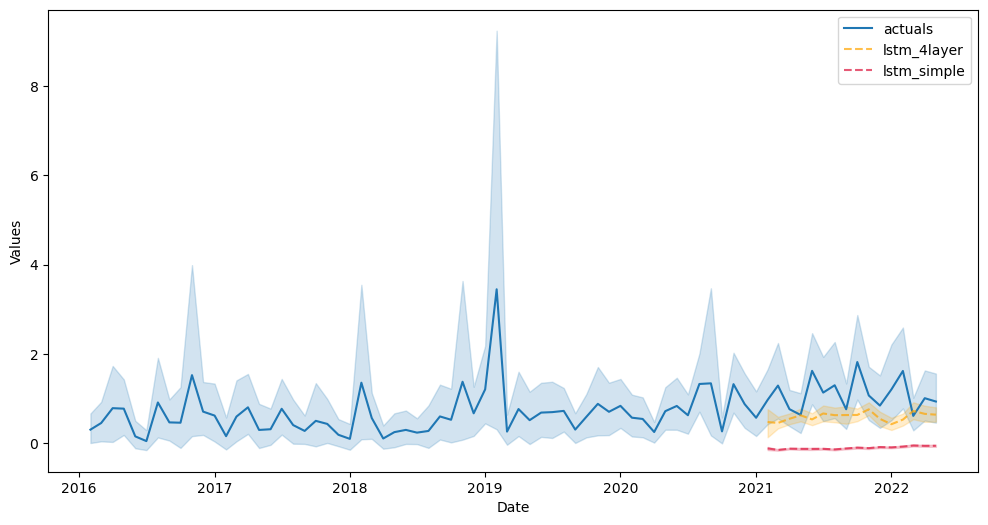

In [156]:
f3.manual_forecast(
    lags=2, # adjust - likely too large 
    batch_size=15, # likely too large 
    epochs=5, # likely more than we need 
    call_me='lstm_8layer_2lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    plot_loss=True,
    learning_rate=0.01, # ""
    lstm_layer_sizes=(8,)*3, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*3, # probably excessive
    loss='MeanSquaredError'
)

# f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer','lstm_4layer_2lag'],order_by='TestSetRMSE')

In [186]:
np.sqrt(3.6572e-04)

0.01912380715234286

Epoch 1/25
303/303 [==============================] - 7s 9ms/step - loss: 6.6854e-04 - val_loss: 3.9604e-04
Epoch 2/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6421e-04 - val_loss: 3.8410e-04
Epoch 3/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6687e-04 - val_loss: 3.9026e-04
Epoch 4/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6343e-04 - val_loss: 4.0149e-04
Epoch 5/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6379e-04 - val_loss: 3.7186e-04
Epoch 6/25
303/303 [==============================] - 2s 5ms/step - loss: 6.6367e-04 - val_loss: 4.1781e-04
Epoch 7/25
303/303 [==============================] - 2s 5ms/step - loss: 6.6532e-04 - val_loss: 3.8700e-04
Epoch 8/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6508e-04 - val_loss: 4.2640e-04
Epoch 9/25
303/303 [==============================] - 1s 5ms/step - loss: 6.6445e-04 - val_loss: 3.8953e-04
Epoch 10/25
303/303 [=======

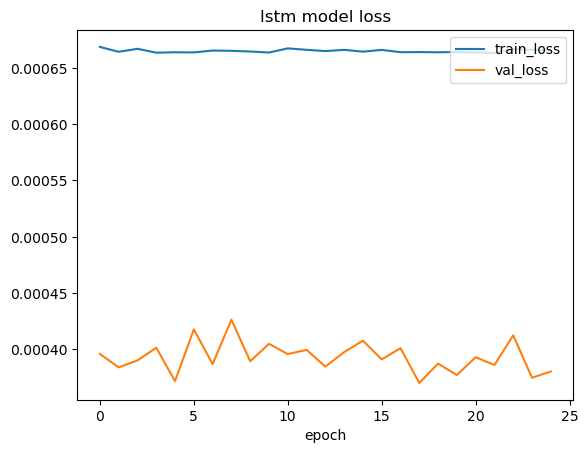

Epoch 1/25
308/308 [==============================] - 7s 10ms/step - loss: 6.6676e-04 - val_loss: 3.9001e-04
Epoch 2/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5487e-04 - val_loss: 3.8444e-04
Epoch 3/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5832e-04 - val_loss: 3.7308e-04
Epoch 4/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5848e-04 - val_loss: 3.9008e-04
Epoch 5/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5426e-04 - val_loss: 3.6467e-04
Epoch 6/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5727e-04 - val_loss: 3.6309e-04
Epoch 7/25
308/308 [==============================] - 1s 5ms/step - loss: 6.5586e-04 - val_loss: 3.8729e-04
Epoch 8/25
308/308 [==============================] - 2s 5ms/step - loss: 6.5825e-04 - val_loss: 3.8191e-04
Epoch 9/25
308/308 [==============================] - 1s 5ms/step - loss: 6.5931e-04 - val_loss: 3.8128e-04
Epoch 10/25
308/308 [======

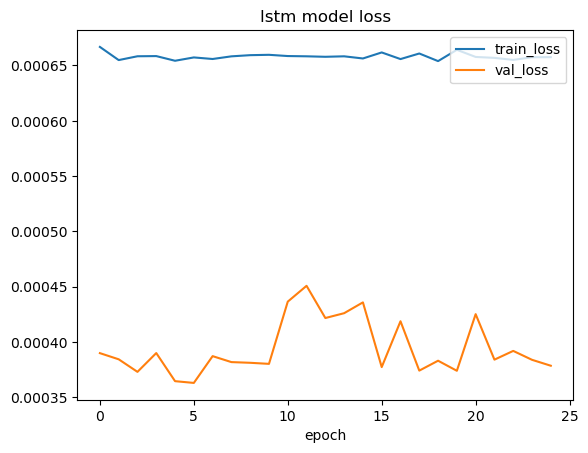

<Axes: xlabel='Date', ylabel='Values'>

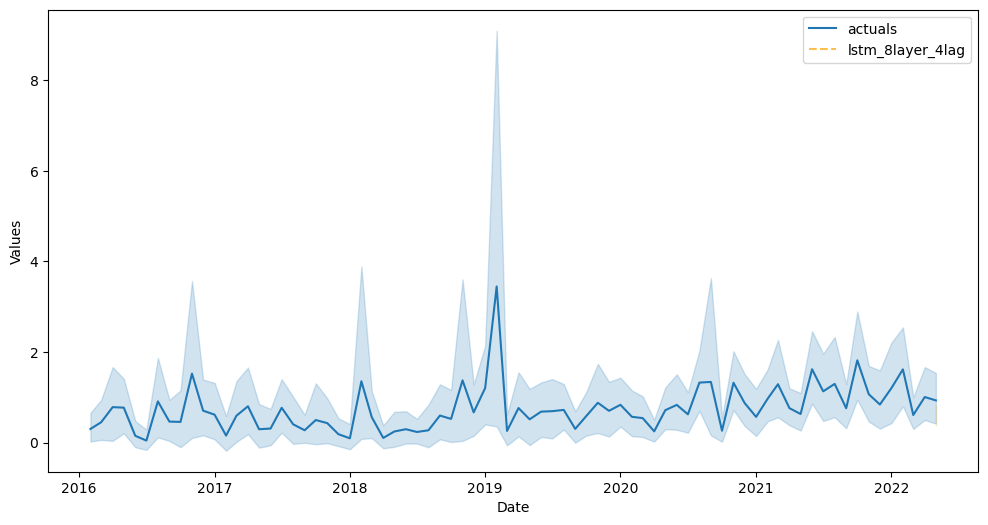

In [224]:
f3.set_test_length(40)       # 1. 12 observations to test the results
f3.set_estimator('lstm') # LSTM neural network

f3.manual_forecast(
    lags=6, # adjust - likely too large 
    batch_size=10, # likely too large 
    epochs=25, # likely more than we need 
    call_me='lstm_8layer_4lag',
    validation_split=.3,
    activation='tanh', # experiment with activation 
    optimizer='Adam', # experiment with optimization
    learning_rate=0.01, # ""
    lstm_layer_sizes=(8,)*5, # likely MUCH too large --> conducive to overfit 
    dropout=(0,)*5, # probably excessive
    plot_loss=True,
    loss='MeanSquaredError'
)
f3.plot_test_set(ci=False,models=['lstm_8layer_4lag'])
#f3.plot_test_set(ci=False,models=['lstm_simple','lstm_4layer_1lag','lstm_8layer_2lag','lstm_16layer_4lag'],order_by='TestSetRMSE')

In [214]:
lstm_4layer_2lag_vals = f3.export_fitted_vals('lstm_4layer_2lag')

In [215]:
lstm_4layer_2lag_vals.shape

(4405, 4)

In [223]:
lstm_4layer_2lag_vals.head()

,DATE,Actuals,FittedVals,Residuals
0,2016-02-01,-0.587441,0.185512,-0.772953
1,2016-02-01,-0.587441,0.185550,-0.772991
2,2016-02-01,0.082055,0.185550,-0.103495
3,2016-02-01,1.458942,0.185506,1.273435
4,2016-02-01,-0.587441,0.185397,-0.772837


In [217]:
lstm_4layer_2lag_vals.DATE.unique()

array(['2016-02-01T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-04-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-06-01T00:00:00.000000000', '2016-07-01T00:00:00.000000000',
       '2016-08-01T00:00:00.000000000', '2016-09-01T00:00:00.000000000',
       '2016-10-01T00:00:00.000000000', '2016-11-01T00:00:00.000000000',
       '2016-12-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2017-05-01T00:00:00.000000000',
       '2017-06-01T00:00:00.000000000', '2017-07-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-05-01

In [241]:
lstm_trainval_merge = lstm_trainval.iloc[:4405,:58]

In [242]:
lstm_trainval_merge.shape

(4405, 58)

In [246]:
lstm_4layer_2lag_res = pd.concat([lstm_trainval_merge,lstm_4layer_2lag_vals], axis=1)
lstm_4layer_2lag_res.to_csv("model_output/lstm_4layer_2lag_res.csv")

In [ ]:
# grid search - fix

# from scalecast import GridGenerator

# GridGenerator.get_example_grids()
# models = ['ridge','lasso','xgboost','lightgbm','knn']
# f0.tune_test_forecast(
#     models,
#     limit_grid_size = .2,
#     feature_importance = True, # save pfi feature importance for each model?
#     cross_validate = True, # cross validate? if False, using a seperate validation set that the user can specify
#     rolling = True, # rolling time series cross validation?
#     k = 3, # how many folds?
# 


In [158]:
# calc rsme from val loss
np.sqrt(3.6576e-04)

0.019124852940611073